## Kaggle Materialization Experiment
In this notebook, we make the plot in Figure 5 and 6 of Section 6.3.

Experiment result is located here:

'./experiment_results/remote/materialization/kaggle_home_credit/cloud-41/2019-10-19/21-12.csv'


In [239]:
# numpy and pandas for data manipulation
import sys
# Suppress warnings
import warnings
import seaborn as sns
import matplotlib as plt
import networkx as nx
import numpy as np
import pandas as pd
import matplotlib.ticker as ticker
import os
import matplotlib2tikz
plt.style.use('seaborn')
sns.set(style="whitegrid")
sns.set_style({'grid.color': '.5'})
plt.rc('hatch', color='white', linewidth=1)
plt.use('pgf')


FONT_SIZE = 32
plt.rcParams.update({
    "lines.markersize": 15,
    "pgf.texsystem": "pdflatex",
    "text.usetex": True,   
    "font.family": "serif",
    "font.serif": [],
    "font.sans-serif": [],
    "font.monospace": [],
    "axes.labelsize": FONT_SIZE,     
    "font.size": FONT_SIZE,
    "legend.fontsize": FONT_SIZE, 
    "xtick.labelsize": FONT_SIZE,
    "ytick.labelsize": FONT_SIZE,
    #"figure.figsize": figsize(1.0), 
     "pgf.preamble": [
        r"\usepackage[utf8x]{inputenc}",    # use utf8 fonts becasue your computer can handle it :)
        r"\usepackage[T1]{fontenc}",        # plots will be generated using this preamble
        ]
})
warnings.filterwarnings('ignore')

# matplotlib and seaborn for plotting
import matplotlib.pyplot as plt
%matplotlib inline
ROOT_RESULT_FOLDER = '/Users/bede01/Documents/work/phd-papers/ml-workload-optimization/experiment_results/remote'


SYSTEM_COLOR = sns.color_palette()[0]
BASELINE_COLOR = sns.color_palette()[1]
HELIX_COLOR = sns.color_palette()[2]
ALL_COLOR = sns.color_palette()[3]

WRITE_DIRECTORY_ROOT = \
'/Users/bede01/Documents/work/phd-papers/ml-workload-optimization/papers/images/experiment-results'

output_directory = WRITE_DIRECTORY_ROOT + '/kaggle_home_credit/materialization'
def create_folder(path):
    if not os.path.exists(os.path.dirname(path)):
        try:
            os.makedirs(os.path.dirname(path))
        except OSError as exc:  # Guard against race condition
            if exc.errno != errno.EEXIST:
                raise
                
def savefig(filename):
    plt.savefig('{}.pgf'.format(filename), bbox_inches='tight')
    plt.savefig('{}.pdf'.format(filename), bbox_inches='tight')

In [240]:
result_folder = ROOT_RESULT_FOLDER + '/materialization/kaggle_home_credit'
result_file = result_folder + '/cloud-41/2020-02-03/21-14.csv'
#result_file = result_folder + '/cloud-41/2019-10-19/21-12.csv'

In [241]:
HEADERS = [
    'timestamp', 'exp_id', 'repo', 'workload', 'mat_type','budget', 'total_mat', 'total_size','run_time'
]
mat_map = {'simple':'HM','storage_aware':'SA', 'all':'ALL', 'helix':'HL'}
materialization_result = pd.read_csv(result_file, header=None, names=HEADERS)
materialization_result['mat_type'] = materialization_result['mat_type'].replace(mat_map)
materialization_result[['budget', 'total_mat', 'total_size']] = materialization_result[['budget', 'total_mat', 'total_size']] / (1024 * 1024)
materialization_result['budget'] = materialization_result['budget'].astype(int)
materialization_result = materialization_result[materialization_result.budget!=0]

In [268]:
def plot_execution_time(df, loc=None):
    cat_df = df[df.mat_type != 'ALL']
    #print cat_df
    cat = sns.catplot(
        data=cat_df,
        x='budget',
        y='run_time',
        hue='mat_type',
        kind='bar',
        height=4,
        aspect=3,
        errwidth=3,
        errcolor='0',
        ci='sd',
        hue_order=['SA', 'HM', 'HL'],
        palette={
            'SA': SYSTEM_COLOR,
            'HM': BASELINE_COLOR,
            'HL': HELIX_COLOR
        },
        legend=False)
    cat.set_xlabels('Budget (GB)')
    cat.set_ylabels('Total Run Time (s)')
    all_mat_cost = df[df.mat_type == 'ALL'].run_time.values[0]
    ax = cat.axes[0][0]
    ax.axhline(all_mat_cost, dashes=(2, 1), linewidth=5, color=ALL_COLOR)
    ax.set(xlim=(-0.6, 3.6))
    #ax.set(ylim=(0, 2000))
    ax.set_yticks([0, 500, 1000, 1500, 2000])
    ax.yaxis.set_major_formatter(ticker.EngFormatter(sep=''))
    #plt.tick_params(labelsize=TICK_LABEL_SIZE)

    budgets = len(df.budget.unique()) - 1
    for i, bar in enumerate(cat.ax.patches):
        if i < budgets:
            h = '/'
        elif i < 2*budgets:
            h = 'X'
        else:
            h = 'O'
        bar.set_edgecolor('black')
        bar.set_hatch(h)
    from matplotlib.lines import Line2D
    lg = plt.legend()
    handles = lg.legendHandles
    labels = ['SA', 'HM', 'HL', 'ALL']

    handles.append(
        Line2D([0], [1], color=ALL_COLOR, linewidth=5, dashes=(2, 1)))

    lg = plt.legend(
        handles,
        labels,
        frameon=True,
        borderpad=0.2,
        #loc='upper center',
        handlelength=1.5,
        handletextpad=0.1,
        #fontsize=TICK_LABEL_SIZE,
        ncol=1,
        columnspacing=0.5,
        bbox_to_anchor=(1, 1.1))
    lg.get_frame().set_edgecolor('black')
    lg.get_frame().set_linewidth(2.0)
    return cat

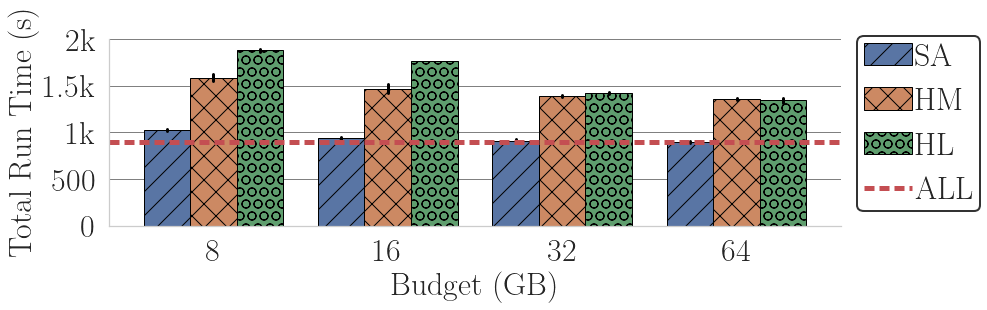

In [269]:
df = materialization_result.groupby(['exp_id','mat_type','budget'])['run_time'].sum().reset_index()
plot = plot_execution_time(df)
savefig(output_directory+'/run-time')

In [85]:
df.groupby(['mat_type','budget']).mean()

run_time
mat_type budget             
ALL      1        914.346883
HL       8       1876.966843
         16      1763.941443
         32      1423.242559
         64      1340.427216
HM       8       1582.575033
         16      1466.554698
         32      1386.309476
         64      1356.488321
SA       8       1022.890372
         16       935.586957
         32       909.640032
         64       893.159826

In [221]:
LW = 8
FONT_SIZE = 30
plt.rcParams.update({
    "lines.markersize": 20,
    "pgf.texsystem": "pdflatex",
    "text.usetex": True,   
    "font.family": "serif",
    "font.serif": [],
    "font.sans-serif": [],
    "font.monospace": [],
    "axes.labelsize": FONT_SIZE,     
    "font.size": FONT_SIZE,
    "legend.fontsize": FONT_SIZE, 
    "xtick.labelsize": FONT_SIZE,
    "ytick.labelsize": FONT_SIZE,
    #"figure.figsize": figsize(1.0), 
     "pgf.preamble": [
        r"\usepackage[utf8x]{inputenc}",    # use utf8 fonts becasue your computer can handle it :)
        r"\usepackage[T1]{fontenc}",        # plots will be generated using this preamble
        ]
})
plt.rc('hatch', color='white', linewidth=4)

In [222]:
execution_order = {
    'start_here_a_gentle_introduction': 1,
    'introduction_to_manual_feature_engineering': 2,
    'introduction_to_manual_feature_engineering_p2': 3,
    'fork_cridata_start_here_a_gentle_introduction': 4,
    'fork_taozhongxiao_start_here_a_gentle_introduction': 5,
    'fork_introduction_to_manual_feature_engineering': 6,
    'fork_introduction_to_manual_feature_engineering_p2': 7,
    'fork_join_start_here_intro': 8
}
df = materialization_result[['exp_id','workload','mat_type','budget','total_mat','total_size']]
df['workload_order'] = df['workload'].replace(execution_order)

In [225]:
def plot_sizes(df, ax, fig_name, budget):
    plot = sns.lineplot(
        data=df,
        x='workload_order',
        y='total_mat',
        hue='mat_type',
        style='mat_type',
        err_style='band',
        markers={
            'SA': "o",
            'HM': "^",
            'HL':'X',
            'ALL': 'P'
        },
        lw=LW,
        hue_order=['SA', 'HM', 'HL', 'ALL'],
        dashes={
            'SA': (1, 0),
            'HM': (3, 1),
            'HL': (2, 2),
            'ALL': (1, 1)
        },
        palette={
            'SA': SYSTEM_COLOR,
            'HM': BASELINE_COLOR,
            'HL': HELIX_COLOR,
            'ALL': ALL_COLOR
        },
        legend='brief')

#     handles = lg.legendHandles
#     labels = ['SA', 'HM', 'HL','ALL']
#     del handles[0]
#     from matplotlib.lines import Line2D
#     handles[0] = Line2D([0], [1],
#                         color=SYSTEM_COLOR,
#                         lw=LW-2,
#                         dashes=(1, 0),
#                         marker="o")
#     handles[1] = Line2D([0], [1],
#                         color=BASELINE_COLOR,
#                         lw=LW-2,
#                         dashes=(3, 1),
#                         marker="^")
#     handles[2] = Line2D([0], [1],
#                         color=HELIX_COLOR,
#                         lw=LW-2,
#                         dashes=(2, 2),
#                         marker="X")
#     handles[3] = Line2D([0], [1],
#                         color=ALL_COLOR,
#                         lw=LW-2,
#                         dashes=(1, 1),
#                         marker="v")
#     legend = plt.legend(
#         handles,
#         labels,
#         loc='upper center',
#         handlelength=1.5,
#         handletextpad=0.1,
#         fontsize=TICK_LABEL_SIZE,
#         numpoints=1,
#         ncol=4,
#         columnspacing=0.5,
#         bbox_to_anchor=(0.5, 1.26))
    
    plot.set_ylim((0, 140))
    plot.set_xlabel('Workload\n \\textbf{{({}) Budget = {} GB}}'.format(fig_name,budget),labelpad=3)
   # plot.get_yaxis().setvisible(False)
    plot.set_ylabel('Size (GB)')
    #plt.tick_params(labelsize=TICK_LABEL_SIZE)
    plot.set_yticks([0, 25, 50, 75,100,125])
    plot.set_xticklabels(range(1, 9))
    plot.set_xticks(range(1, 9))
    plot.get_legend().remove()
    return plot

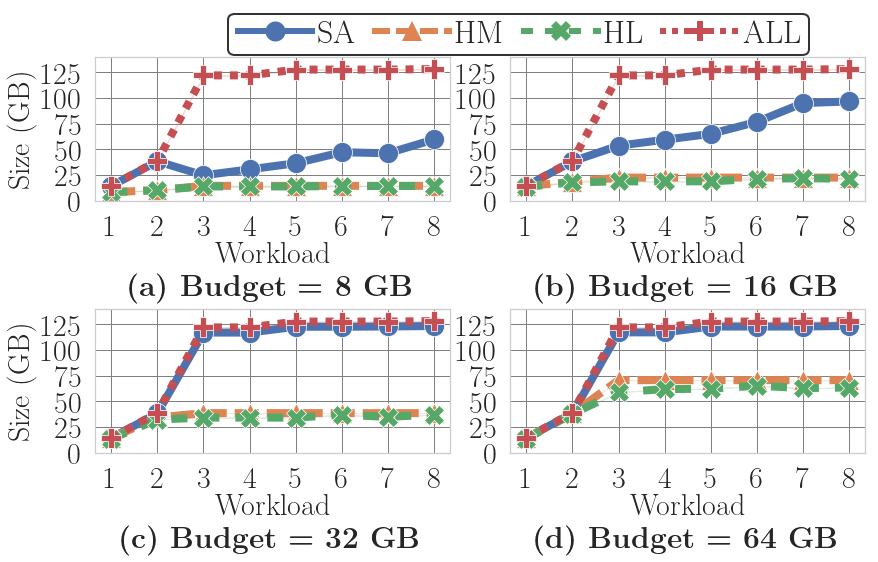

In [234]:
plt.clf()
fig = plt.figure(figsize=(12,7))
ax1 = fig.add_subplot(221)
p1 = plot_sizes(df[(df['budget'] == 8.0) | (df['mat_type'] == 'ALL')],ax=ax1,fig_name='a',budget=8)
ax2 = fig.add_subplot(222)
p2 = plot_sizes(df[(df['budget'] == 16.0) | (df['mat_type'] == 'ALL')],ax=ax2,fig_name='b',budget=16)
ax3 = fig.add_subplot(223)
p3=plot_sizes(df[(df['budget'] == 32.0) | (df['mat_type'] == 'ALL')],ax=ax3,fig_name='c',budget=32)
ax4 = fig.add_subplot(224)
p4=plot_sizes(df[(df['budget'] == 64.0) | (df['mat_type'] == 'ALL')],ax=ax4,fig_name='d',budget=64)

p2.yaxis.label.set_visible(False)
p4.yaxis.label.set_visible(False)

handles = []
labels = ['SA', 'HM', 'HL','ALL']
# del handles[0]
from matplotlib.lines import Line2D
handles.append(Line2D([0], [1],
                    color=SYSTEM_COLOR,
                    lw=6,
                    dashes=(1, 0),
                    marker="o"))
handles.append(Line2D([0], [1],
                    color=BASELINE_COLOR,
                    lw=LW-2,
                    dashes=(3, 1),
                    marker="^"))
handles.append(Line2D([0], [1],
                    color=HELIX_COLOR,
                    lw=LW-2,
                    dashes=(2, 2),
                    marker="X"))
handles.append(Line2D([0], [1],
                    color=ALL_COLOR,
                    lw=LW-2,
                    dashes=(1, 1),
                    marker="P"))
legend = fig.legend(
    handles,
    labels,
    borderpad=0.2,
    frameon=True,
    loc='upper center',
    handlelength=2.5,
    handletextpad=0.1,
    fontsize=TICK_LABEL_SIZE,
    numpoints=1,
    ncol=4,
    columnspacing=0.5,
    bbox_to_anchor=(0.6, 1.12))
legend.get_frame().set_edgecolor('black')
legend.get_frame().set_linewidth(2.0)

plt.tight_layout(pad=0,h_pad=0,w_pad=0)


savefig(output_directory+'/mat_sizes')

In [162]:
def plot_sizes(df, loc=None):
    plt.figure(figsize=(8, 4))
    plot = sns.lineplot(
        data=df,
        x='workload_order',
        y='total_mat',
        hue='mat_type',
        style='mat_type',
        err_style='band',
        markers={
            'SA': "o",
            'HM': "^",
            'HL':'X',
            'ALL': 'v'
        },
        lw=LW,
        hue_order=['SA', 'HM', 'HL', 'ALL'],
        dashes={
            'SA': (1, 0),
            'HM': (3, 1),
            'HL': (2, 2),
            'ALL': (1, 1)
        },
        palette={
            'SA': SYSTEM_COLOR,
            'HM': BASELINE_COLOR,
            'HL': HELIX_COLOR,
            'ALL': ALL_COLOR
        },
        legend='brief')

    lg = plt.legend(
        loc='upper center',
        handlelength=1.5,
        handletextpad=0.1,
        fontsize=TICK_LABEL_SIZE,
        ncol=3,
        columnspacing=0.5,
        bbox_to_anchor=(0.55, 1.2))
    handles = lg.legendHandles
    labels = ['SA', 'HM', 'HL','ALL']
    del handles[0]
    from matplotlib.lines import Line2D
    handles[0] = Line2D([0], [1],
                        color=SYSTEM_COLOR,
                        lw=LW-2,
                        dashes=(1, 0),
                        marker="o")
    handles[1] = Line2D([0], [1],
                        color=BASELINE_COLOR,
                        lw=LW-2,
                        dashes=(3, 1),
                        marker="^")
    handles[2] = Line2D([0], [1],
                        color=HELIX_COLOR,
                        lw=LW-2,
                        dashes=(2, 2),
                        marker="X")
    handles[3] = Line2D([0], [1],
                        color=ALL_COLOR,
                        lw=LW-2,
                        dashes=(1, 1),
                        marker="v")
    legend = plt.legend(
        handles,
        labels,
        loc='upper center',
        handlelength=1.5,
        handletextpad=0.1,
        fontsize=TICK_LABEL_SIZE,
        numpoints=1,
        ncol=4,
        columnspacing=0.5,
        bbox_to_anchor=(0.5, 1.26))

    plot.set_ylim((0, 140))
    plot.set_xlabel('Workload', fontsize=AXIS_FONT)
    plot.set_ylabel('Size (GB)', fontsize=AXIS_FONT)
    plt.tick_params(labelsize=TICK_LABEL_SIZE)
    plot.set_yticks([0, 25, 50, 75, 100, 125])
    plot.set_xticklabels(range(1, 9))
    plot.set_xticks(range(1, 9))
    if loc is not None:
        plt.savefig(loc, bbox_inches='tight')

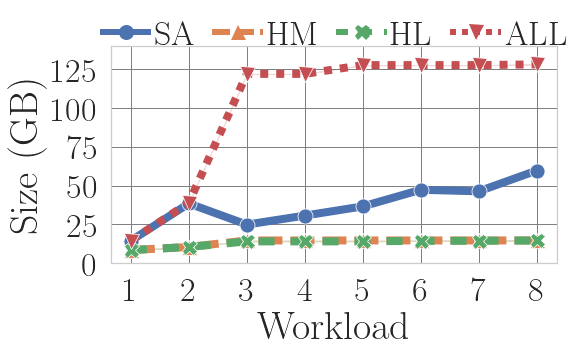

In [90]:
#plot_sizes(df[(df['budget'] == 8.0) | (df['mat_type'] == 'ALL')], output_directory+'/size-8.pgf')
plot_sizes(df[(df['budget'] == 8.0) | (df['mat_type'] == 'ALL')])

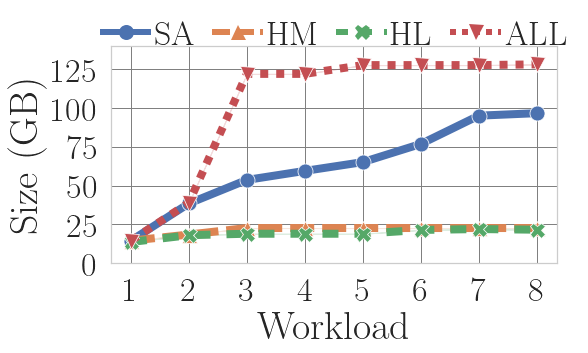

In [91]:
#plot_sizes(df[(df['budget'] == 16.0) | (df['mat_type'] == 'ALL')], output_directory+'/size-16.pgf')
plot_sizes(df[(df['budget'] == 16.0) | (df['mat_type'] == 'ALL')])

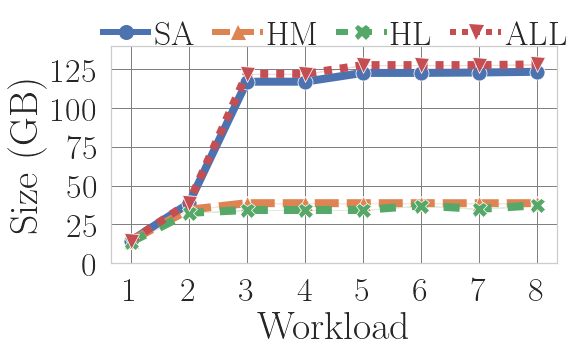

In [92]:
#plot_sizes(df[(df['budget'] == 32.0) | (df['mat_type'] == 'ALL')], output_directory+'/size-32.pgf')
plot_sizes(df[(df['budget'] == 32.0) | (df['mat_type'] == 'ALL')])

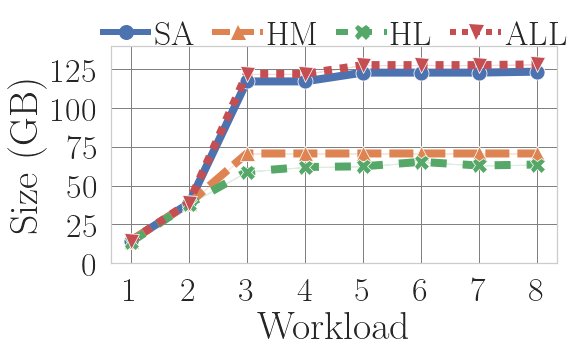

In [93]:
#plot_sizes(df[(df['budget'] == 64.0) | (df['mat_type'] == 'ALL')], output_directory+'/size-64.pgf')
plot_sizes(df[(df['budget'] == 64.0) | (df['mat_type'] == 'ALL')])